In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

bins = 200

import numpy
import observations.dimensions.one.sampling as observe
import torch
import flows.utils

from defaults.plot import *

enable_latex_export()

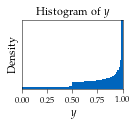

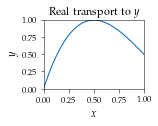

In [2]:
ys = observe.sample(1)

# Lower bins so figure is better (singularity makes it hard to see)
plt.hist(numpy.transpose(ys)[0], bins=80, density = True, rasterized=True)
plt.title(r"Histogram of $y$")
plt.xlabel(r"$y$")
plt.ylabel("Density")
no_axis(x=True)
plt.savefig("figures/1d/density-y.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

plt.title(r"Real transport to $y$")
plt.plot(numpy.linspace(0, 1,observe.samplesize), [observe.T(x) for x in numpy.linspace(0, 1, observe.samplesize)])
plt.xlabel("$x$")
plt.ylabel(r"$y$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig("figures/1d/push-forward-uniform-y-unknown.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

In [17]:
# We can try to just learn the density y, by applying a normalizing flow to the samples
learning_ys = numpy.transpose(observe.sample(0))[0].reshape(-1, 1)

y_flow_dist, y_transform = flows.utils.normal_to_samples(learning_ys, normalize=True, steps=1601, lr=1e-2)
y_samples = y_flow_dist.sample(torch.Size([observe.samplesize])).detach().numpy()

step: 0, loss: 1.510963797569275
step: 200, loss: -0.34153011441230774
step: 400, loss: -0.46544626355171204
step: 600, loss: -0.48226046562194824
step: 800, loss: -0.4487907886505127
step: 1000, loss: -0.489418089389801
step: 1200, loss: -0.4912360608577728
step: 1400, loss: -0.4921676814556122
step: 1600, loss: -0.4927823543548584


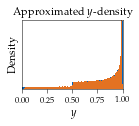

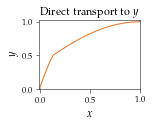

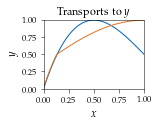

In [18]:
plt.title("Approximated $y$-density")
plt.hist(numpy.transpose(observe.sample(0))[0], bins=80, density = True, label="Sampled Density of $y$", rasterized=True)
plt.hist(y_samples, bins=bins, density=True, label="Approximated Density of $y$", rasterized=True)
plt.xlabel("$y$")
plt.ylabel("Density")
no_axis(x=True)
plt.xlim(0, 1)
#plt.legend()
plt.savefig("figures/1d/density-y-nf.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

from scipy.special import erfinv
Gauss = lambda x, mu, sigma: mu + numpy.sqrt(2)*sigma*erfinv(2*x-1)
standard_gauss = numpy.vectorize(lambda x: Gauss(x, 0, 1))

input = numpy.linspace(0, 1, 10002)[1:-1] # the erfinv causes problems with the bounds, so we remove 0 and 1
input_normal = standard_gauss(input)
mapped = y_transform(torch.tensor([[x] for x in input_normal])).detach().numpy()

plt.title("Direct transport to $y$")
plt.plot(input, mapped, color=TUMAccentOrange)
plt.xlabel(r"$x$")
plt.ylabel("$y$")
plt.xlim(-0.005, 1)
plt.ylim(0, 1.025)
plt.savefig("figures/1d/push-forward-uniform-y-direct.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

plt.title(r"Transports to $y$")
plt.plot(input, [observe.T(x) for x in input], label="Real (unknown) push-forward")
plt.plot(input, mapped, label="Invertible push-forward")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.xlim(0, 1)
plt.ylim(0, 1)
#plt.legend()
plt.savefig("figures/1d/push-forward-uniform-y-direct-comparison.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

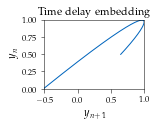

In [211]:
#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.title("Time delay embedding")
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.savefig("figures/1d/diffeomorphic.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

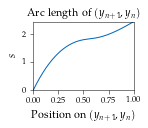

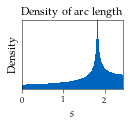

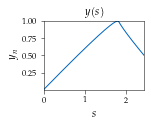

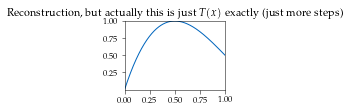

In [3]:
from observations.utils import arclen

alen = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])

ys_0 = (numpy.transpose(ys)[0])[1:]
def y_by_s(s):
    #TODO: this could be done via interpolation, but we just search for the first one that is bigger
    return ys_0[numpy.argmax(alen >= s)]

y_by_s_vectorized = numpy.vectorize(lambda x: y_by_s(x))

plt.title("Arc length of $(y_{n+1}, y_n)$") # linear on 0-1
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen)
plt.xlim(0, 1)
plt.xlabel("Position on $(y_{n+1}, y_n)$")
plt.ylabel("$s$")
plt.savefig("figures/1d/arc-length.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

plt.title("Density of arc length")
plt.hist(alen, bins=bins+1, density=True, label="Sampled Density of $s$", rasterized=True)
plt.xlabel("$s$")
plt.ylabel("Density")
no_axis(x=True)
plt.savefig("figures/1d/density-s.pdf", dpi=dpi*2, bbox_inches='tight')
plt.show()

plt.title("$y(s)$")
plt.plot(alen, (numpy.transpose(ys)[0])[1:])
plt.xlabel('$s$')
plt.ylabel('$y_{n}$')
plt.savefig("figures/1d/y-of-s.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

plt.title("Reconstruction, but actually this is just $T(x)$ exactly (just more steps)") # so we don't really know our x
plt.plot(numpy.linspace(0, 1, len(alen)), [y_by_s(a) for a in alen])
plt.show()

## This was mostly everything that is given by the sampling process and construction of the arc length $s$
We now learn the map from $s$ to $x$ (or vice versa) and can reconstruct the original curve and density

In [7]:
%%time

flow_dist, transform = flows.utils.normal_to_samples(alen.reshape(-1, 1), steps=3001, lr=5e-3)
s_samples = flow_dist.sample(torch.Size([observe.samplesize])).detach().numpy()

step: 0, loss: 7.0765790939331055
step: 200, loss: 0.9392451643943787
step: 400, loss: 0.6634511351585388
step: 600, loss: 0.6382662057876587
step: 800, loss: 0.6302546858787537
step: 1000, loss: 0.6261332035064697
step: 1200, loss: 0.6233848333358765
step: 1400, loss: 0.6213790774345398
step: 1600, loss: 0.6198636293411255
step: 1800, loss: 0.6186322569847107
step: 2000, loss: 0.6176677942276001
step: 2200, loss: 0.6168368458747864
step: 2400, loss: 0.6161412000656128
step: 2600, loss: 0.6155693531036377
step: 2800, loss: 0.6150609850883484
step: 3000, loss: 0.6146096587181091
Wall time: 2min 49s


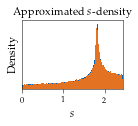

In [231]:
plt.title("Approximated $s$-density")
plt.hist(alen, bins=400, density=True, label="Sampled Density of $s$", rasterized=True)
plt.hist(s_samples, bins=400, density=True, label='Approximated Density of $s$', rasterized=True)
plt.xlabel("$s$")
plt.ylabel("Density")
no_axis(x=True)
plt.xlim([0, max(alen)])
#plt.legend()
plt.savefig("figures/1d/density-s-nf.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

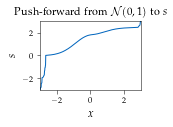

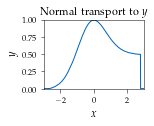

In [252]:
input = numpy.linspace(-3, 3, 10000)
mapped = transform(torch.tensor([[x] for x in input])).detach().numpy()

plt.title(r"Push-forward from $\mathcal{N}(0,1)$ to $s$")
plt.plot(input, mapped)
plt.xlabel("$x$")
plt.ylabel("$s$")
plt.savefig("figures/1d/push-forward-normal-arc-length.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

plt.title("Normal transport to $y$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0,1)
plt.plot(input, y_by_s_vectorized(mapped))
plt.savefig("figures/1d/push-forward-normal-y.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

In [10]:
%%time

# Now we change the assumptions
import observations.dimensions.one.multimodal as multimodal

X_bimodal = multimodal.simulate_bimodal()
flow_dist_bimodal, transform_bimodal = flows.utils.normal_to_samples(X_bimodal, steps=1601, lr=5e-3)
bimodal_samples = flow_dist_bimodal.sample(torch.Size([observe.samplesize])).detach().numpy()

step: 0, loss: 3.262956142425537
step: 200, loss: 1.3363337516784668
step: 400, loss: 1.2155482769012451
step: 600, loss: 1.189824104309082
step: 800, loss: 1.1841189861297607
step: 1000, loss: 1.1817539930343628
step: 1200, loss: 1.1803247928619385
step: 1400, loss: 1.1792714595794678
step: 1600, loss: 1.1786634922027588
Wall time: 2min 56s


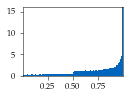

In [236]:
bimodal_samples_normal = transform_bimodal.inv(torch.tensor(bimodal_samples))
bimodal_samples_s = transform(bimodal_samples_normal)

plt.hist(y_by_s_vectorized(bimodal_samples_s.detach().numpy()), bins=bins, density=True)
plt.show()

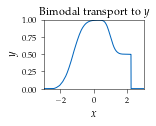

In [253]:
mapped_bimodal = transform_bimodal.inv(torch.tensor([[x] for x in input])).detach().numpy().reshape(-1)
mapped_bimodal_normal = transform(torch.tensor([[x] for x in mapped_bimodal])).detach().numpy().reshape(-1)

plt.title("Bimodal transport to $y$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0,1)
plt.plot(input, y_by_s_vectorized(mapped_bimodal_normal))
plt.savefig("figures/1d/push-forward-bimodal-y.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

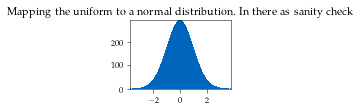

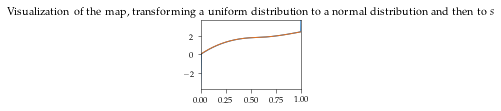

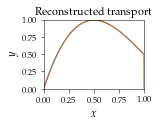

In [250]:
# We now look at the unifrom transported

input = numpy.linspace(0, 1, 10002)[1:-1] # the erfinv causes problems with the bounds, so we remove 0 and 1
input_normal = standard_gauss(input)

# TODO delete? It is a good sanity check
plt.title("Mapping the uniform to a normal distribution. In there as sanity check")
plt.hist(input_normal, bins=100, rasterized=True)
plt.show()

mapped = transform(torch.tensor([[x] for x in input_normal])).detach().numpy()

plt.title("Visualization of the map, transforming a uniform distribution to a normal distribution and then to $s$")
plt.plot(input, mapped)
plt.plot(numpy.linspace(0, 1, len(alen)), alen)
plt.show()

uniform_real_s_y = y_by_s_vectorized(mapped)
plt.title(r"Reconstructed transport")
plt.plot(input, [observe.T(x) for x in input], label="Real (unknown) push-forward")
plt.plot(input, uniform_real_s_y, label="Approximated push-forward")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig("figures/1d/push-forward-uniform-y.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

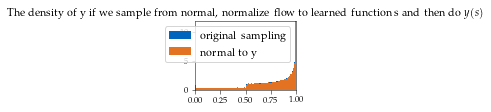

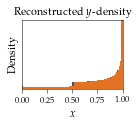

In [267]:
plt.title("The density of y if we sample from normal, normalize flow to learned function s and then do $y(s)$")
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True, label="original sampling", rasterized=True)
plt.hist(y_by_s_vectorized(s_samples), bins=100, density=True, label="normal to y", rasterized=True)
plt.legend()
plt.show()

plt.title("Reconstructed $y$-density")
plt.hist(numpy.transpose(observe.sample(0))[0], bins=80, density = True, label="Sampled Density of $y$", rasterized=True)
plt.hist(y_by_s_vectorized(mapped), bins=80, density=True, label="Approximated Density of $y$", rasterized=True)
#plt.legend(loc="upper left")
plt.ylabel("Density")
plt.xlabel("$x$")
no_axis(x=True)
plt.savefig("figures/1d/density-y-reconstructed.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

## Now we look into learning the dynamic on the arc length s

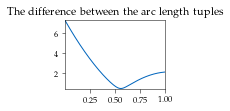

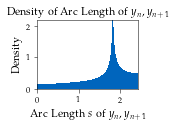

In [4]:
from observations.utils import lags
dt = 1 / observe.samplesize

training_tuples = list(zip(*lags(arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), 1)))
real_difference = [abs(t0 - t1) / dt for t0, t1 in training_tuples]

plt.title("The difference between the arc length tuples") # TODO it  is not log scaled as of now
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference)
plt.show()

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.title("Density of Arc Length of $y_{n}, y_{n+1}$")
plt.hist(s, bins=100, density=True, rasterized=True)
plt.xlabel("Arc Length $s$ of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

In [5]:
import dynamics.nets as nets
import dynamics.utils
import torch.nn as nn
from scipy.integrate import solve_ivp

def f(t, y):
    return model.one_step(torch.FloatTensor([y])).detach().numpy()[0]

def s_n1(model, s_n):
    return model(torch.tensor([[s_n]]).float()).item()

def s_n1_tensor(model, s_n):
    return model(s_n.float())

def show_model(model):
    fitted_values = s_n1_tensor(model, torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1))
    training_tuples_fitted = torch.cat((torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1), fitted_values), 1).detach().numpy()

    difference = numpy.abs(training_tuples_fitted[:, 0] - training_tuples_fitted[:, 1]) / dt
    t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
    sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

    plt.title("Derivative of $s$") #  $(s_n, s_{n+1}) -> | s_{n+1} - s_{n}|$
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference, label="Observed Samples")
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], difference, label="Neural Prediction", color=TUMAccentGreen) # given s_n calculate s_n+1
    # TODO: INFO: This following line is basically identical, but we would have to vectorize it and I do not have any more time as of now
    #plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], [f(0, [x]) for x in numpy.transpose(training_tuples)[0]], label="Neural Prediction", color=TUMAccentGreen) # given s_n calculate s_n+1

    plt.xlabel("Position on $(y_{n+1}, y_n)$")
    plt.ylabel("Gradient")
    #plt.legend()
    plt.savefig("figures/1d/s-dynamics-gradiant.pdf", dpi=dpi, bbox_inches='tight')
    plt.show()

    plt.title("Arc length of $(y_{n+1}, y_n)$")
    plt.plot(t_eval[1:], alen, label="Observed Samples")
    plt.plot(t_eval, sol.y[0], label="Integrated Neural Prediction", color=TUMAccentGreen)
    plt.ylabel("s")
    plt.xlabel("Position on $(y_{n+1}, y_n)$")
    #plt.legend()
    plt.savefig("figures/1d/s-dynamics-arc-length.pdf", dpi=dpi, bbox_inches='tight')
    plt.show()

    plt.title("Prediction of $s_{n+1}$ given $s_n$")
    plt.plot(numpy.linspace(0, s[-1], 1000), [s_n1(model, x) for x in numpy.linspace(0, s[-1], 1000)], label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
    plt.xlabel("$s_{n}$")
    plt.ylabel("$s_{n+1}$")
    plt.show()

def train_model():
    model = nets.RK4N(input_size=1, num_param=1, hidden_size=20, h=dt, num_hidden_layers=2)

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad=True)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    train_loader, val_loader = dynamics.utils.training_validator_splitter(training_tuples, bs=300)

    # Losses
    train_losses = []
    val_losses = []
    min_val_loss = 1e100

    for epoch in range(1, 2500):  # loop over the dataset multiple times
        train_loss = 0.0
        for _, (inputs, labels) in enumerate(train_loader, 0):
            inputs = torch.unsqueeze(inputs, 1).float()
            labels = torch.unsqueeze(labels, 1).float()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # For statistics
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        with torch.no_grad():
            for _, (inputs, labels) in enumerate(train_loader, 0):
                inputs = torch.unsqueeze(inputs, 1).float()
                labels = torch.unsqueeze(labels, 1).float()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print('[Epoch: %3d] training loss: %.9f  validation loss: %.9f' %
                (epoch, train_loss, val_loss))

        if  val_loss < min_val_loss:
            min_val_loss = val_loss

            show_model(model)

        model.save("full_one_dimensional/non_normalized/" + str(epoch) + ".model")

    plt.plot(train_losses, label="training loss")
    plt.plot(val_losses, label="validation loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

    return model

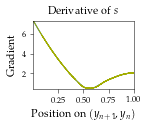

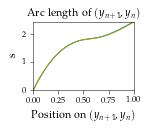

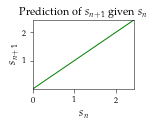

In [6]:
# To actually train the model use the following line:
# On my machine it took a while (about 30min?)
#model = train_model()

model = torch.load("models/1D-arclength-trained.model")
model.eval()

show_model(model)

0.0%
20.0%
40.0%
60.0%
80.0%


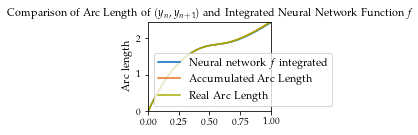

In [18]:
t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

acc = 0
accumulated_points = []
for i in range(observe.samplesize):
    accumulated_points.append(acc)
    acc = s_n1(model, acc)
    if i % 10000 == 0:
        print(str((i / observe.samplesize) * 100) + "%")

plt.title("Comparison of Arc Length of $(y_n, y_{n+1})$ and Integrated Neural Network Function $f$")
plt.ylabel("Arc length")
plt.plot(t_eval, sol.y[0], label="Neural network $f$ integrated")
plt.plot(t_eval, accumulated_points, label="Accumulated Arc Length")
plt.plot(t_eval[1:], alen, label="Real Arc Length")
plt.legend()
plt.show()

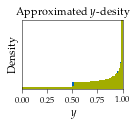

In [268]:
t_eval = numpy.linspace(0, observe.samplesize * dt, int(observe.samplesize))
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

# Comparison between original density of $y$ and neural reconstruction of $s$ transported with $y(s)$
plt.title("Approximated $y$-desity")
plt.hist(numpy.transpose(observe.sample(0))[0], bins=80, density = True, label="Sampled Density of $y$", rasterized=True)
new_ys = [y_by_s(s) for s in sol.y[0]]
plt.hist(new_ys, bins=80, density = True, label="Density of Neural estimated Arc Length", color=TUMAccentGreen, rasterized=True)
#plt.legend(loc="upper left")
no_axis(x=True)
plt.ylabel("Density")
plt.xlabel("$y$")
plt.savefig("figures/1d/y-density-s-dynamics.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

We can also use the integrated $f$ instead of the actual $s$ to learn to normalizing flow and then transport the density form x to y over s.

If the function is learned well enough, there should be nearly no difference

step: 0, loss: 1.3482999801635742
step: 200, loss: 0.6042725443840027
step: 400, loss: 0.59479820728302
step: 600, loss: 0.5933177471160889
step: 800, loss: 0.5926056504249573
step: 1000, loss: 0.5923219919204712


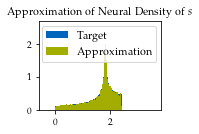

In [20]:
s_integrated_flow_dist, s_integrated_transform = flows.utils.normal_to_samples(sol.y[0].reshape(-1, 1), normalize=True, steps=1001, lr=1e-2)
s_integrated_flow_samples = s_integrated_flow_dist.sample(torch.Size([observe.samplesize])).detach().numpy()

plt.title("Approximation of Neural Density of $s$")
plt.hist(sol.y[0], bins=200, density=True, label="Target", rasterized=True)
plt.hist(s_integrated_flow_samples, bins=200, density=True, label="Approximation", color=TUMAccentGreen, rasterized=True)
plt.legend()
plt.show()

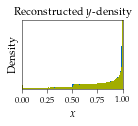

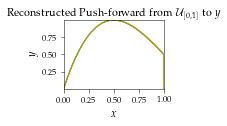

In [266]:
input = numpy.linspace(0, 1, 10002)[1:-1] # the erfinv causes problems with the bounds, so we remove 0 and 1
input_normal = standard_gauss(input)
mapped = s_integrated_transform(torch.tensor([[x] for x in input_normal])).detach().numpy()

plt.title("Reconstructed $y$-density")
plt.hist(numpy.transpose(observe.sample(0))[0], bins=80, density = True, label="Sampled Density of $y$", rasterized=True)
plt.hist(y_by_s_vectorized(mapped), bins=bins, density=True, label="Approximated Density of $y$", color=TUMAccentGreen, rasterized=True)
#plt.legend(loc="upper left")
plt.ylabel("Density")
plt.xlabel("$x$")
no_axis(x=True)
#plt.savefig("figures/1d/density-y-reconstructed.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

plt.title(r"Reconstructed Push-forward from $\mathcal{U}_{[0,1]}$ to $y$")
plt.plot(input, [observe.T(x) for x in input], label="Real (unknown) push-forward")
plt.plot(input, uniform_real_s_y, label="Approximated push-forward (Arc Length)")
plt.plot(input, y_by_s_vectorized(mapped), label="Approximated push-forward (Learned Arc Length)")
plt.xlabel(r"$x$")
plt.ylabel("$y$")
#plt.legend()
plt.xlim(0, 1)
plt.savefig("figures/1d/push-forward-uniform-y-full.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

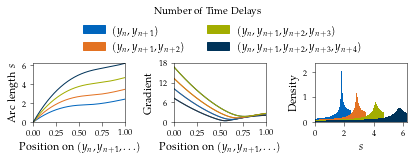

In [56]:
# Generally, we need 2n + 1 (=3) time delay embeddings, but that does not mean that more are not useful
ys_long = observe.sample(5)
alen_2 = arclen([numpy.transpose(ys_long)[0], numpy.transpose(ys_long)[1]])
alen_3 = arclen([numpy.transpose(ys_long)[0], numpy.transpose(ys_long)[1], numpy.transpose(ys_long)[2]])
alen_4 = arclen([numpy.transpose(ys_long)[0], numpy.transpose(ys_long)[1], numpy.transpose(ys_long)[2], numpy.transpose(ys_long)[3]])
alen_5 = arclen([numpy.transpose(ys_long)[0], numpy.transpose(ys_long)[1], numpy.transpose(ys_long)[2], numpy.transpose(ys_long)[3], numpy.transpose(ys_long)[4]])

plt.subplots(1, 3, figsize=(5.8, 1.8))

ttl = plt.gcf().suptitle("Number of Time Delays")
ttl.set_position([0.5, 1.2])


plt.subplot(1, 3, 1)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen_2, label = "$i = 1$, $y_{n}, y_{n+1}$")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen_3, label = "$i = 2$, $y_{n}, y_{n+1}, y_{n+2}$")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen_4, label = "$i = 3$, $y_{n}, y_{n+1}, y_{n+2}, y_{n+3}$")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen_5, label = "$i = 4$, $y_{n}, y_{n+1}, y_{n+2}, y_{n+3}, y_{n+4}$")
plt.xlabel(r'Position on $(y_n, y_{n+1}, \dots)$')
plt.ylabel('Arc length $s$')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.yticks([0, 2, 4, 6])
plt.xlim(0, 1)

alen_2_tuple_diff = [abs(t0 - t1) / dt for t0, t1 in list(zip(*lags(alen_2, 1)))]
alen_3_tuple_diff = [abs(t0 - t1) / dt for t0, t1 in list(zip(*lags(alen_3, 1)))]
alen_4_tuple_diff = [abs(t0 - t1) / dt for t0, t1 in list(zip(*lags(alen_4, 1)))]
alen_5_tuple_diff = [abs(t0 - t1) / dt for t0, t1 in list(zip(*lags(alen_5, 1)))]

#plt.title("The difference between the arc length tuples") # TODO it  is not log scaled as of now
plt.subplot(1, 3, 2)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_2_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_3_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_4_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_5_tuple_diff)
plt.xlim(0, 1)
plt.ylim(0, alen_5_tuple_diff[0])
plt.xlabel(r'Position on $(y_n, y_{n+1}, \dots)$')
plt.ylabel("Gradient")
plt.xticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(1, 3, 2)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_2_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_3_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_4_tuple_diff)
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], alen_5_tuple_diff)
plt.xlim(0, 1)
plt.ylim(0, alen_5_tuple_diff[0])
plt.yticks([0, 6, 12, 18])
plt.xlabel(r'Position on $(y_n, y_{n+1}, \dots)$')
plt.ylabel("Gradient")

plt.subplot(1, 3, 3)
plt.hist(alen_2, bins=200, density=True, rasterized=True)
plt.hist(alen_3, bins=200, density=True, rasterized=True)
plt.hist(alen_4, bins=200, density=True, rasterized=True)
plt.hist(alen_5, bins=200, density=True, rasterized=True)
plt.xlabel("$s$")
plt.ylabel("Density")
plt.xticks([0, 2, 4, 6])

plt.tight_layout()

from matplotlib.patches import Patch

plt.legend(handles = [Patch(facecolor=TUMBlue, edgecolor=TUMBlue),
                      Patch(facecolor=TUMAccentOrange, edgecolor=TUMAccentOrange),
                      Patch(facecolor=TUMAccentGreen, edgecolor=TUMAccentGreen),
                      Patch(facecolor=TUMSecondaryBlue2, edgecolor=TUMSecondaryBlue2)],   # The labels for each line
           labels=["$(y_n, y_{n+1})$", "$(y_n, y_{n+1}, y_{n+2})$", r"$(y_n,  y_{n+1},  y_{n+2}, y_{n+3})$", r"$(y_n,  y_{n+1},  y_{n+2},  y_{n+3}, y_{n+4})$"],   # The labels for each line
           loc="upper center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="",  # Title for the legend
           ncol=2,
           frameon=False,
           bbox_to_anchor=(-1, 1.75))

plt.savefig("figures/1d/diffeomorphic-more-delays.pdf", dpi=dpi, bbox_inches="tight")
plt.show()